In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline
import tensorflow as tf
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [3]:
n_s = 1e5
θ = np.random.uniform(0, 10, int(n_s))
d = np.transpose(np.array([np.random.normal(0, θ) for i in range(200)]).reshape((10, 10, 2, int(n_s))), (3, 0, 1, 2)) 

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, LeakyReLU
from multipole_kernels.multipole_kernels_keras import MultipoleKernel as MK

In [5]:
model = Sequential()
model.add(MK(kernel_size=[5, 5], 
             ℓ=[0, 1],
             output_filters=[10, 10], 
             input_filters=2, 
             padding="VALID", 
             input_shape=(10, 10, 2)))
model.add(LeakyReLU(0.01))
model.add(MK(kernel_size=[5, 5], 
             ℓ=[0, 1], 
             output_filters=[3, 3], 
             input_filters=model.layers[0].num_output_filters, 
             padding="VALID"))
model.add(LeakyReLU(0.01))
model.add(Flatten())
model.add(Dense(1))
model.add(Activation("relu"))
model.compile(optimizer="adam", loss="mse")
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
multipole_kernel (MultipoleK (None, 6, 6, 30)          430       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6, 6, 30)          0         
_________________________________________________________________
multipole_kernel_1 (Multipol (None, 2, 2, 9)           1809      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2, 2, 9)           0         
_________________________________________________________________
flatten (Flatten)            (None, 36)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 37        
______________________

In [6]:
model.fit(d, θ, epochs=100, batch_size=10000)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
100000/100000 [==============================] - 5s 47us/sample - loss: 6.5901
Epoch 2/100
100000/100000 [==============================] - 4s 38us/sample - loss: 2.2305
Epoch 3/100
100000/100000 [==============================] - 4s 35us/sample - loss: 1.4632
Epoch 4/100
100000/100000 [==============================] - 4s 40us/sample - loss: 1.0994
Epoch 5/100
100000/100000 [==============================] - 4s 45us/sample - loss: 0.9310
Epoch 6/100
100000/100000 [==============================] - 6s 62us/sample - loss: 0.8244
Epoch 7/100
100000/100000 [==============================] - 4s 40us/sample - loss: 0.7462
Epoch 8/100
100000/100000 [==============================] - 4s 37us/sample - loss: 0.6861
Epoch 9/100
100000/100000 [==============================] - 4s 40us/sample - loss: 0.6372
Epoch 10/100
100000/100000 [==============================] - 4s 36us/sample - loss: 0.5966
Epoch 11/100
100000/100000 [=============

100000/100000 [==============================] - 5s 47us/sample - loss: 0.1934
Epoch 88/100
100000/100000 [==============================] - 5s 52us/sample - loss: 0.1928
Epoch 89/100
100000/100000 [==============================] - 4s 36us/sample - loss: 0.1921
Epoch 90/100
100000/100000 [==============================] - 5s 46us/sample - loss: 0.1914
Epoch 91/100
100000/100000 [==============================] - 6s 56us/sample - loss: 0.1909
Epoch 92/100
100000/100000 [==============================] - 4s 36us/sample - loss: 0.1902
Epoch 93/100
100000/100000 [==============================] - 4s 42us/sample - loss: 0.1894
Epoch 94/100
100000/100000 [==============================] - 6s 59us/sample - loss: 0.1890
Epoch 95/100
100000/100000 [==============================] - 4s 36us/sample - loss: 0.1882
Epoch 96/100
100000/100000 [==============================] - 4s 38us/sample - loss: 0.1876
Epoch 97/100
100000/100000 [==============================] - 6s 61us/sample - loss: 0.1871
E

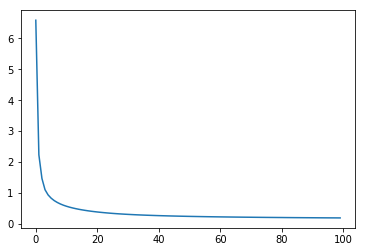

In [7]:
plot(model.history.history["loss"])

In [8]:
θ_test = np.random.uniform(0, 10, int(1e5))
d_test = np.transpose(np.array([np.random.normal(0, θ_test) for i in range(200)]).reshape((10, 10, 2, int(1e5))), (3, 0, 1, 2)) 

In [9]:
θ_pred = model.predict(d_test)

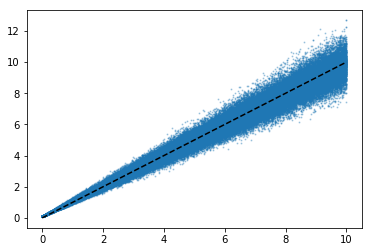

In [10]:
scatter(θ_test, θ_pred, s=1, alpha=0.3)
plot([0, 10], [0, 10], color="black", linestyle="dashed")

In [11]:
w1 = model.layers[0].get_weights()[0]
w2 = model.layers[2].get_weights()[0]

In [14]:
from multipole_kernels.multipole_kernels import multipole_kernels as mk
eval_mk1 = mk(kernel_size=[5, 5], 
              ℓ=[0, 1],
              output_filters=[10, 10], 
              input_filters=2, 
              placeholder="mk1")
eval_mk2 = mk(kernel_size=[5, 5], 
              ℓ=[0, 1],
              output_filters=[3, 3], 
              input_filters=eval_mk1.num_output_filters, 
              placeholder="mk2")
init = tf.global_variables_initializer()

In [16]:
with tf.Session() as sess:
    sess.run(init)
    k1 = sess.run(eval_mk1.kernel, feed_dict={eval_mk1.w: w1})
    k2 = sess.run(eval_mk2.kernel, feed_dict={eval_mk2.w: w2})

In [17]:
print(k1.shape)
print(k2.shape)

(5, 5, 2, 30)
(5, 5, 30, 9)


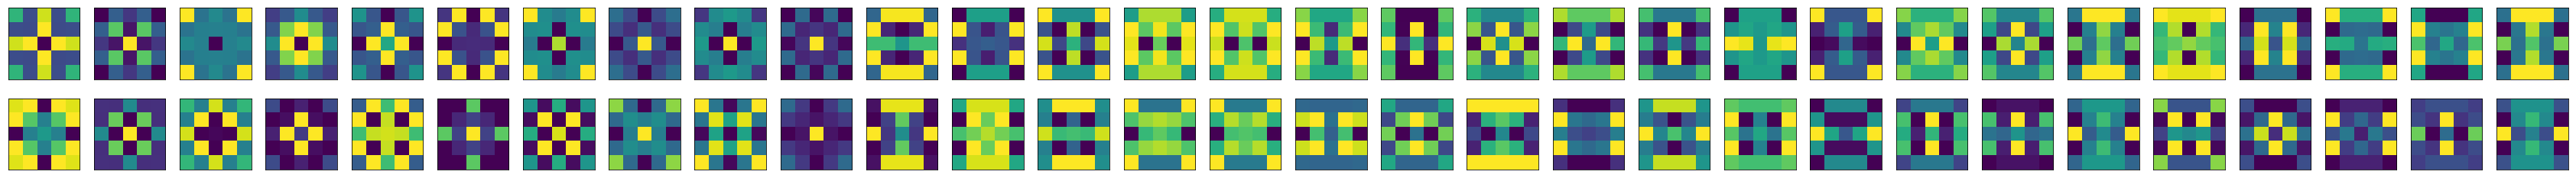

In [18]:
fig, ax = plt.subplots(k1.shape[2], k1.shape[3], figsize=(2 * k1.shape[3], 2 * k1.shape[2]))
for i in range(k1.shape[2]):
    for j in range(k1.shape[3]):
        ax[i, j].imshow(k1[:, :, i, j])
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

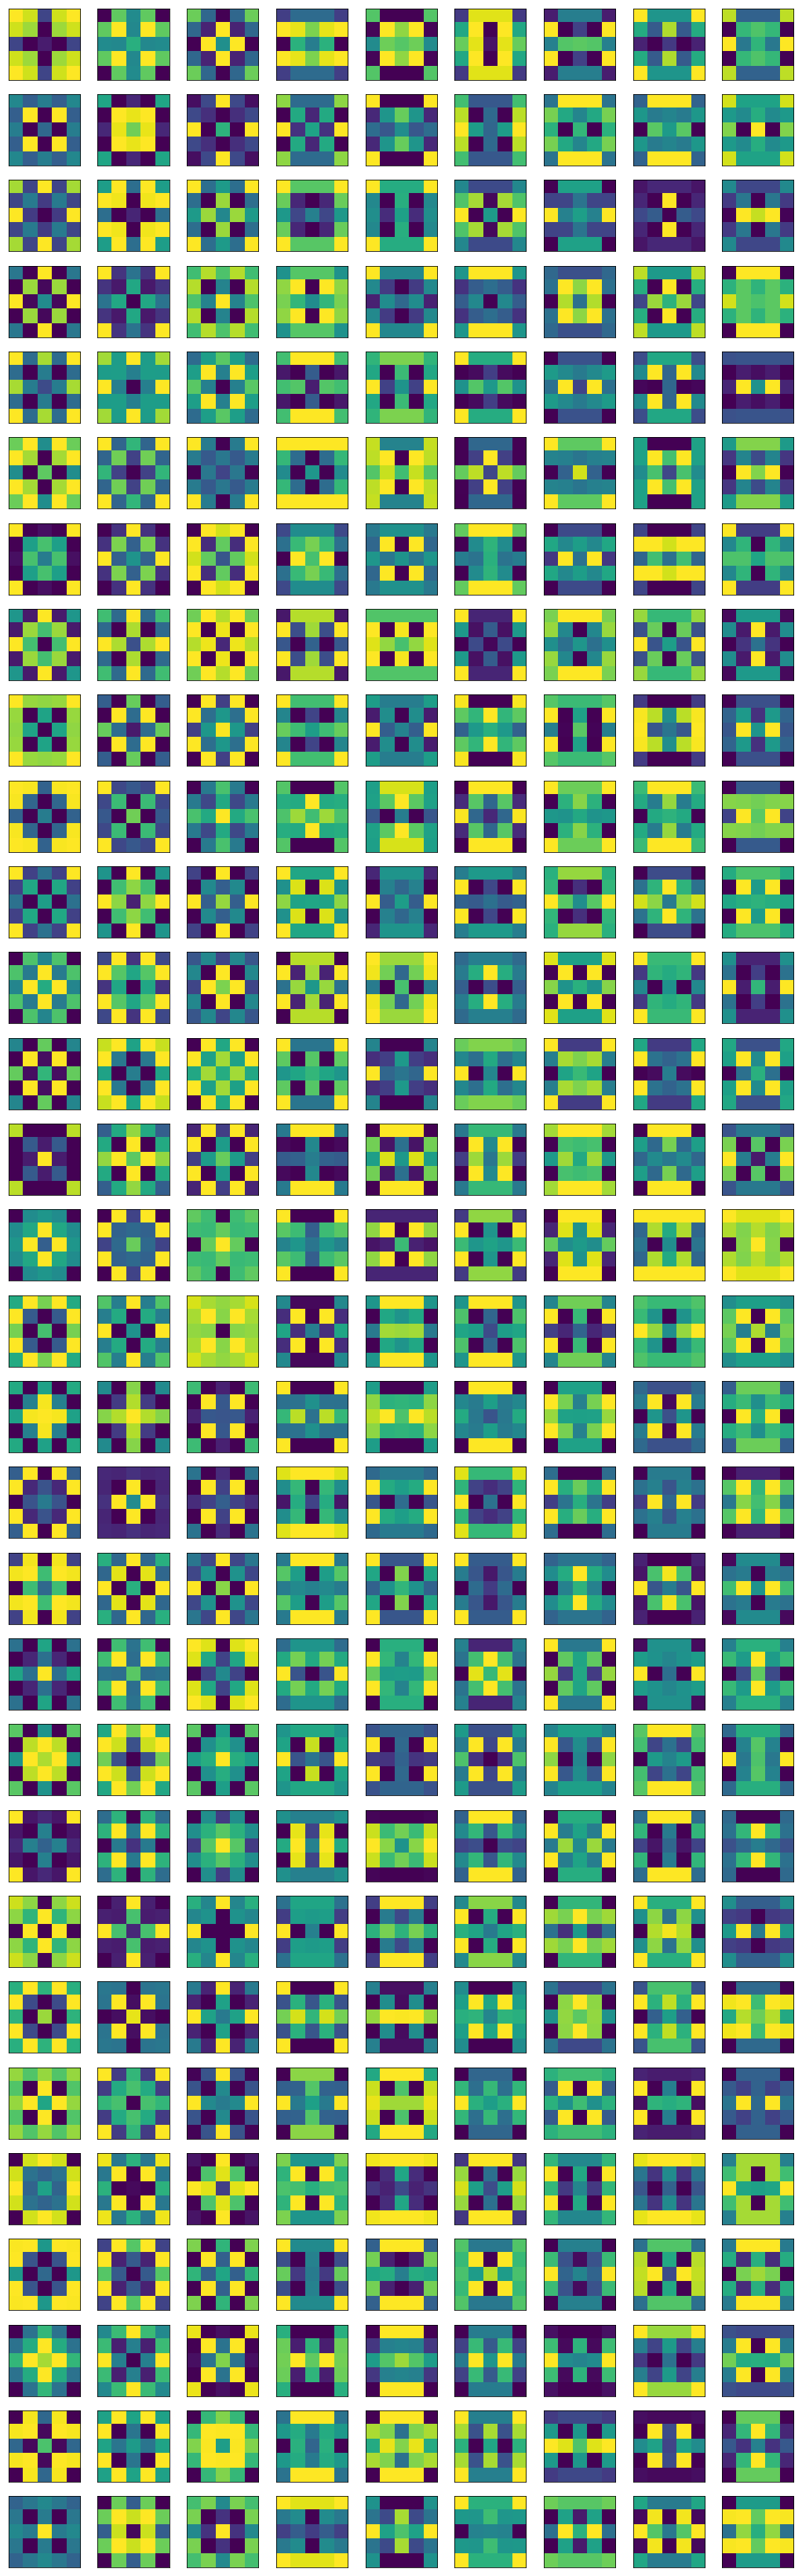

In [19]:
fig, ax = plt.subplots(k2.shape[2], k2.shape[3], figsize=(2 * k2.shape[3], 2 * k2.shape[2]))
for i in range(k2.shape[2]):
    for j in range(k2.shape[3]):
        ax[i, j].imshow(k2[:, :, i, j])
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])